In [1]:
#|hide
from fastrl.test_utils import initialize_notebook
initialize_notebook()

In [2]:
#|default_exp agents.dqn.target

In [3]:
#|export
# Python native modules
from copy import deepcopy
from typing import Optional,Callable,Tuple
# Third party libs
import torchdata.datapipes as dp
from torchdata.dataloader2.graph import traverse_dps,DataPipe
import torch
from torch import nn,optim
# Local modules
from fastrl.pipes.core import find_dp
from fastrl.memory.experience_replay import ExperienceReplay
from fastrl.loggers.core import BatchCollector,EpochCollector
from fastrl.learner.core import LearnerBase,LearnerHead
from fastrl.loggers.vscode_visualizers import VSCodeDataPipe
from fastrl.agents.dqn.basic import (
    LossCollector,
    RollingTerminatedRewardCollector,
    EpisodeCollector,
    StepBatcher,
    TargetCalc,
    LossCalc,
    ModelLearnCalc,
    DQN,
    DQNAgent
)

In [4]:
#|hide
import logging
from fastrl.core import default_logging

In [5]:
#|hide
logging.basicConfig(**default_logging())

# DQN Target
> DQN that uses snapshots from the NN module to stabilize training



## Training DataPipes

In [6]:
#|export
class TargetModelUpdater(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe=None,target_sync=300):
        self.source_datapipe = source_datapipe
        if source_datapipe is not None:
            self.learner = find_dp(traverse_dps(self),LearnerBase)
            self.learner.target_model = deepcopy(self.learner.model)
        self.target_sync = target_sync
        self.n_batch = 0
        
    def reset(self):
        self.learner = find_dp(traverse_dps(self),LearnerBase)
        self.learner.target_model = deepcopy(self.learner.model)
        
    def __iter__(self):
        if self._snapshot_state.NotStarted: 
            self.reset()
        for batch in self.source_datapipe:
            if self.n_batch%self.target_sync==0:
                self.learner.target_model.load_state_dict(self.learner.model.state_dict())
            self.n_batch+=1
            yield batch

In [7]:
#|export
class TargetModelQCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe=None):
        self.source_datapipe = source_datapipe
        
    def __iter__(self):
        self.learner = find_dp(traverse_dps(self),LearnerBase)
        for batch in self.source_datapipe:
            self.learner.done_mask = batch.terminated.reshape(-1,)
            with torch.no_grad():
                self.learner.next_q = self.learner.target_model(batch.next_state)
            self.learner.next_q = self.learner.next_q.max(dim=1).values.reshape(-1,1)
            self.learner.next_q[self.learner.done_mask] = 0 
            yield batch

In [8]:
#|export
def DQNTargetLearner(
    model,
    dls,
    logger_bases:Optional[Callable]=None,
    loss_func=nn.MSELoss(),
    opt=optim.AdamW,
    lr=0.005,
    bs=128,
    max_sz=10000,
    nsteps=1,
    device=None,
    batches=None
) -> LearnerHead:
    learner = LearnerBase(model,dls=dls[0])
    learner = BatchCollector(learner,batches=batches)
    learner = EpochCollector(learner)
    if logger_bases: 
        learner = logger_bases(learner)
        learner = RollingTerminatedRewardCollector(learner)
        learner = EpisodeCollector(learner)
    learner = learner.catch_records()
    learner = ExperienceReplay(learner,bs=bs,max_sz=max_sz)
    learner = StepBatcher(learner,device=device)
    learner = TargetModelQCalc(learner)
    learner = TargetCalc(learner,nsteps=nsteps)
    learner = LossCalc(learner,loss_func=loss_func)
    learner = ModelLearnCalc(learner,opt=opt(model.parameters(),lr=lr))
    learner = TargetModelUpdater(learner,target_sync=300)
    if logger_bases: 
        learner = LossCollector(learner).catch_records()

    if len(dls)==2:
        val_learner = LearnerBase(model,dls[1])
        val_learner = BatchCollector(val_learner,batches=batches)
        val_learner = EpochCollector(val_learner).catch_records(drop=True)
        val_learner = VSCodeDataPipe(val_learner)
        return LearnerHead((learner,val_learner),model)
    else:
        return LearnerHead(learner,model)

Try training with basic defaults...

In [9]:
from fastrl.loggers.vscode_visualizers import VSCodeDataPipe
from fastrl.envs.gym import GymDataPipe
from fastrl.loggers.core import ProgressBarLogger
from fastrl.dataloading.core import dataloaders

In [10]:
# #|eval:false
# # Setup Loggers
# def logger_bases(pipe):
#     pipe = pipe.dump_records()
#     pipe = ProgressBarLogger(pipe)
#     return pipe
# # Setup up the core NN
# torch.manual_seed(0)
# model = DQN(4,2)
# # Setup the Agent
# agent = DQNAgent(model,do_logging=True,max_steps=4000)
# # Setup the DataBlock
# dls = dataloaders(
#     GymDataPipe(
#         ['CartPole-v1']*1,
#         agent=agent,
#         nsteps=1,
#         nskips=1,
#         firstlast=False,
#         bs=1
#     )
# )
# # Setup the Learner
# learner,exp_replay = DQNTargetLearner(
#     model,
#     dls,
#     logger_bases=logger_bases,
#     bs=128,
#     max_sz=100_000,
#     batches=1000
# )
# learner.fit(3)
# # learner.fit(25)

The DQN learns, but I wonder if we can get it to learn faster...

In [11]:
# logging.getLogger('fastrl.loggers.core').setLevel('DEBUG')

In [12]:
#|eval:false
# Setup Loggers
def logger_bases(pipe):
    pipe = pipe.dump_records()
    pipe = ProgressBarLogger(pipe)
    return pipe
# Setup up the core NNa
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = DQNAgent(model,do_logging=True,max_steps=5000)
# Setup the DataBlock
train_pipe = GymDataPipe(
    ['CartPole-v1']*1,
    agent=agent,
    nsteps=2,
    nskips=2,
    firstlast=True,
    bs=1
)
valid_pipe = GymDataPipe(
    ['CartPole-v1']*1,
    agent=agent,
    nsteps=2,
    nskips=2,
    firstlast=True,
    bs=1,
    n=100,
    include_images=True
)
valid_pipe = VSCodeDataPipe(valid_pipe)
dls = dataloaders((train_pipe,valid_pipe))
# Setup the Learner
learner = DQNTargetLearner(
    model,
    dls,
    logger_bases=logger_bases,
    bs=128,
    max_sz=100_000,
    nsteps=2,
    lr=0.001,
    batches=1000
)
# learner.fit(3)
learner.fit(5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

loss,episode,rolling_reward,epoch,batch,epsilon
0.1044316,98,16.44,0,999,0.6296
0.88037467,239,10.85,1,999,0.2708
1.2160527,413,9.46,2,999,0.0200
1.2226686,594,9.39,3,999,0.0200
1.4324946,778,9.44,4,999,0.0200


In [13]:
# exp_replay = find_dp(traverse_dps(learner),ExperienceReplay)
# exp_replay.show()

Creating gif from 200 frames


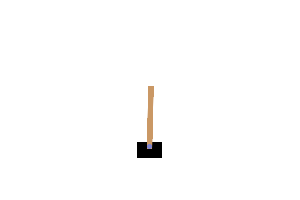

In [16]:
#|hide
#|eval:false
learner.validate(epochs=1,batches=200)

In [15]:
#|hide
#|eval: false
!nbdev_export

/usr/local/lib/python3.8/dist-packages/nbdev/export.py:54: UserWarning: Notebook '/home/fastrl_user/fastrl/nbs/07_Agents/02_Continuous/12u_agents.ppo.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
